Loading user images...
Loaded 7 user images
Loading product images...


c:\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Loaded 219 product images
Calculating similarity scores...

Results:
--------------------------------------------------
Product: 6-hol-125e-40-liberty-tan-original-imah5dthb6vzvhxx.jpeg
Similarity Score: 99.98
--------------------------------------------------
Product: -original-imagzry4bykfpxap2.jpeg
Similarity Score: 99.46
--------------------------------------------------
Product: 6-ausg9026-abros-camel-original-imaghz2byygpqcb22.jpeg
Similarity Score: 99.37
--------------------------------------------------
Product: 6-6003-style-code-zixer-brown-original-imag6x8ppxmzf9yn-bb2.jpeg
Similarity Score: 99.34
--------------------------------------------------
Product: 7-57230241-7-liberty-brown-original-imah4yh3nwhcp3ce2.jpeg
Similarity Score: 99.26
--------------------------------------------------
Product: 6-6003-style-code-zixer-brown-original-imag6x8ppxmzf9yn-bb.jpeg
Similarity Score: 99.17
--------------------------------------------------
Product: -original-imagyxryurgpayvh2.jpeg
S

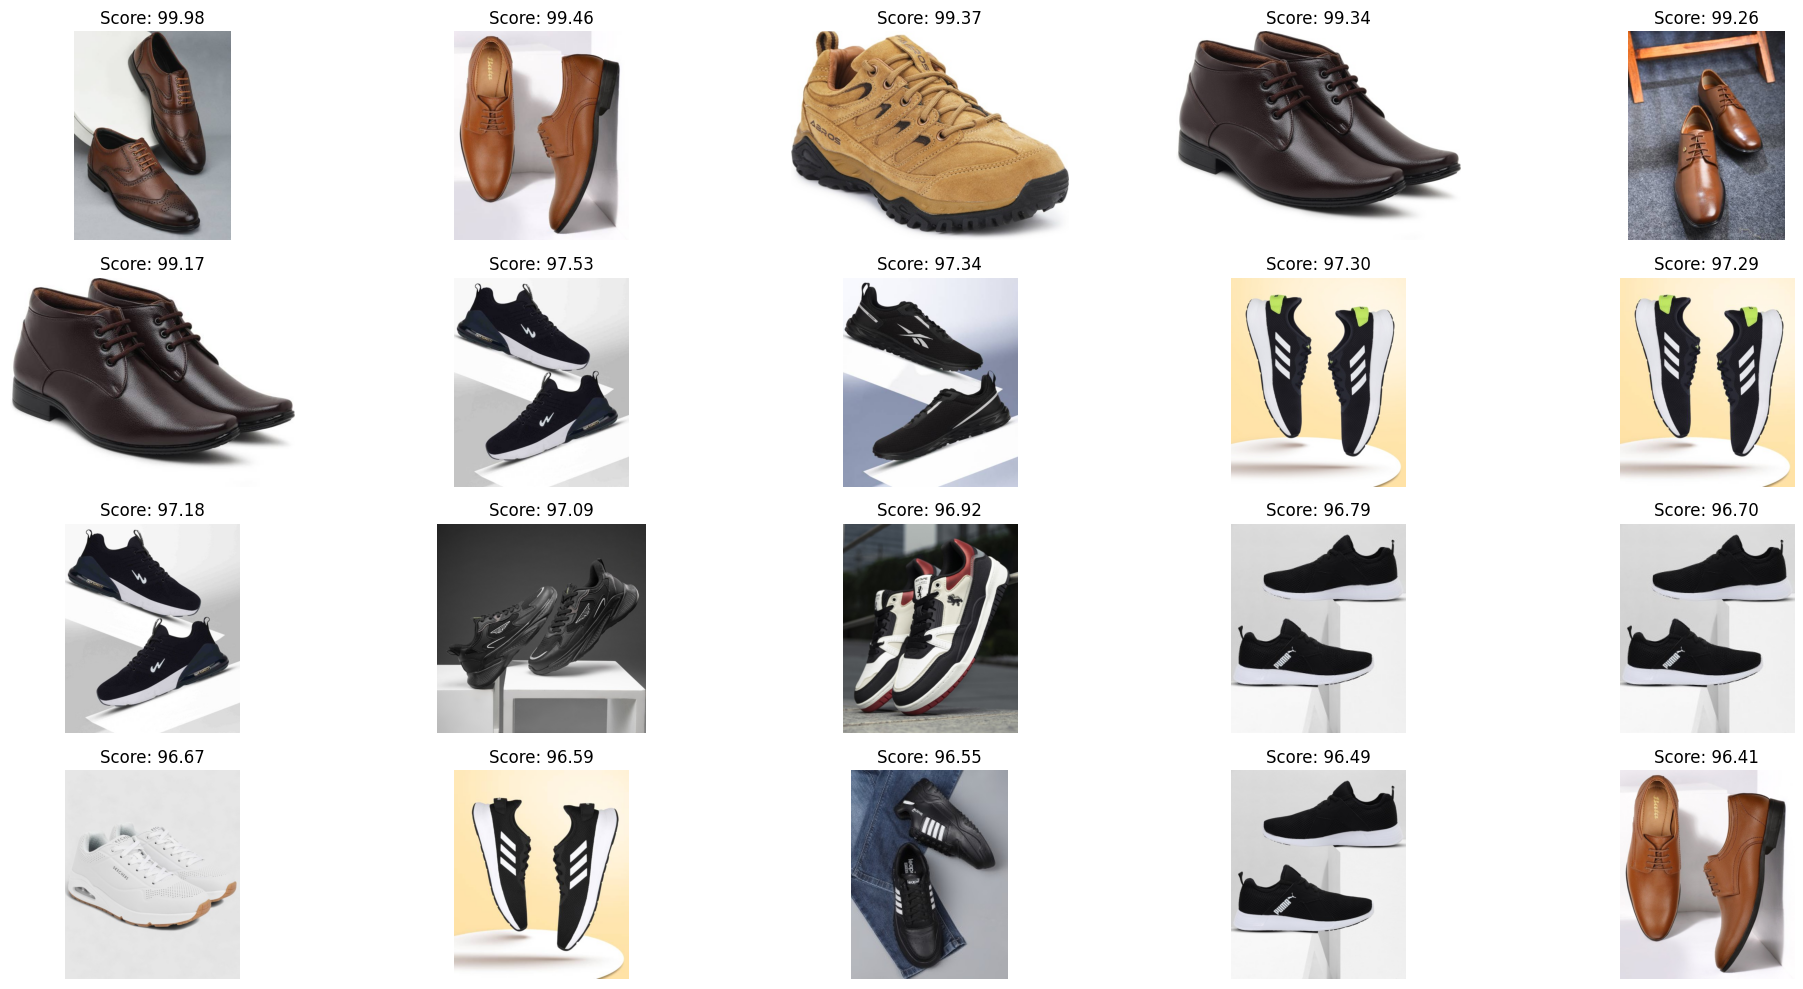

In [4]:
import cv2 as cv
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import os
from colorspacious import cspace_convert
import matplotlib.pyplot as plt

class Image:
    def __init__(self, path):
        self.path = path
        self.img = cv.imread(path)
        if self.img is None:
            raise ValueError(f"Error loading image at {path}. Please check the file path.")
        self.colors = None
        self.palette = None
        self.percentages = None
        
    def process_image(self):
        """Process the image to extract foreground and background color palettes"""
        # Edge detection
        edge_img = edge_detection(self.img)
        
        # Generate masks
        mask2, mask1 = generate_mask(self.img)
        
        # Segment foreground and background
        foreground_img = foreground_segmentation(self.img, mask2, edge_img)
        background_img = background_segmentation(self.img, mask1, edge_img)
        
        # Extract color palettes
        self.colors, self.palette, self.percentages = foreground_palette(foreground_img)

def edge_detection(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = np.float32(img)
    
    dft = cv.dft(img, flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols, 2), np.uint8)
    r = 100
    cv.circle(mask, (ccol, crow), r, (0, 0), thickness=-1)
    
    filtered_dft_shift = dft_shift * mask
    idft_shift = np.fft.ifftshift(filtered_dft_shift)
    img_back = cv.idft(idft_shift)
    img_back = cv.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    return img_back

def generate_mask(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    
    # Define a dynamic rectangle based on image dimensions
    height, width = img.shape[:2]
    rect = (10, 10, width - 20, height - 20)  # 10 pixels margin
    
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    
    cv.grabCut(img, mask, rect, bgd_model, fgd_model, 5, cv.GC_INIT_WITH_RECT)
    
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    mask1 = np.where((mask == 2) | (mask == 0), 1, 0).astype('uint8')
    return mask2, mask1

def foreground_segmentation(img, mask2, img_back):
    foreground = img * mask2[:, :, np.newaxis]
    
    img_back_3ch = cv.normalize(img_back, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    img_back_3ch = cv.merge([img_back_3ch, img_back_3ch, img_back_3ch])
    
    foreground_scaled = cv.multiply(foreground, 1)
    img_back_scaled = cv.multiply(img_back_3ch, 0.5)
    
    foreground_img = cv.add(foreground_scaled, img_back_scaled)
    return foreground_img

def background_segmentation(img, mask1, img_back):
    background = img * mask1[:, :, np.newaxis]
    
    img_back_3ch = cv.normalize(img_back, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    img_back_3ch = cv.merge([img_back_3ch, img_back_3ch, img_back_3ch])
    
    background = cv.multiply(background, 1)
    img_back_scaled = cv.multiply(img_back_3ch, 0.5)
    
    background_img = cv.add(background, img_back_scaled)
    return background_img

def foreground_palette(image, num_colors=10):
    image = cv.resize(image, (100, 100))
    pixels = image.reshape(-1, 3)
    
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)
    
    colors = kmeans.cluster_centers_.astype(int)
    
    counts = Counter(kmeans.labels_)
    total_count = sum(counts.values())
    percentages = [(counts[i] / total_count) * 100 for i in range(num_colors)]
    
    palette = np.zeros((100, 100 * num_colors, 3), dtype=int)
    for i in range(num_colors):
        palette[:, i * 100:(i + 1) * 100] = colors[i]
    
    return colors, palette, percentages

def calculate_ciede2000(color1, color2):
    lab1 = cspace_convert(color1 / 255, "sRGB1", "CIELab")
    lab2 = cspace_convert(color2 / 255, "sRGB1", "CIELab")
    delta_e = np.sqrt(np.sum((lab1 - lab2) ** 2))
    return delta_e

def find_weighted_colors(colors, weights):
    weighted_sum = np.zeros(3)
    total_weight = np.sum(weights)
    
    for color, weight in zip(colors, weights):
        weighted_sum += color * weight
    
    mid_color = weighted_sum / total_weight
    max_color = colors[np.argmax(weights)]
    min_color = colors[np.argmin(weights)]
    
    return max_color, min_color, mid_color

def calculate_similarity(user_colors, user_weights, product_colors, product_weights):
    user_max, user_min, user_mid = find_weighted_colors(user_colors, user_weights)
    product_max, product_min, product_mid = find_weighted_colors(product_colors, product_weights)
    
    distances = [
        calculate_ciede2000(user_max, product_max),
        calculate_ciede2000(user_min, product_min),
        calculate_ciede2000(user_mid, product_mid),
    ]
    
    similarity_score = sum(max(0, 1 - (distance / 100)) * 100 / 3 for distance in distances)
    return similarity_score

def load_images_from_directory(directory):
    image_objects = []
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(directory, filename)
            img_object = Image(path)
            img_object.process_image()
            image_objects.append(img_object)
    return image_objects

def compare_products_with_users(user_images, product_images):
    results = []
    
    # Convert user images to profiles
    user_profiles = []
    for user_image in user_images:
        user_profile = {
            'colors': user_image.colors,
            'weights': user_image.percentages
        }
        user_profiles.append(user_profile)
    
    # Compare each product with user profiles
    for i, product in enumerate(product_images):
        product_colors = product.colors
        product_weights = product.percentages
        
        # Find maximum similarity with any user profile
        max_similarity = 0
        for user_profile in user_profiles:
            similarity = calculate_similarity(
                user_profile['colors'],
                user_profile['weights'],
                product_colors,
                product_weights
            )
            max_similarity = max(max_similarity, similarity)
        
        results.append({
            'product_index': i,
            'product_path': product.path,
            'similarity_score': max_similarity
        })
    
    # Sort results by similarity score
    results.sort(key=lambda x: x['similarity_score'], reverse=True)
    return results

def main():
    # Define directories containing images
    user_directory = r"C:\Users\Dhile\dev\DIP\user"
    product_directory = r"C:\Users\Dhile\dev\DIP\products"
    
    # Load and process images
    print("Loading user images...")
    user_images = load_images_from_directory(user_directory)
    print(f"Loaded {len(user_images)} user images")
    
    print("Loading product images...")
    product_images = load_images_from_directory(product_directory)
    print(f"Loaded {len(product_images)} product images")
    
    # Compare products with user preferences
    print("Calculating similarity scores...")
    results = compare_products_with_users(user_images, product_images)
    
    # Print results
    print("\nResults:")
    print("-" * 50)
    for result in results:
        print(f"Product: {os.path.basename(result['product_path'])}")
        print(f"Similarity Score: {result['similarity_score']:.2f}")
        print("-" * 50)

    # Plot the top 20 images based on similarity scores
    top_n = 20
    top_results = results[:top_n]
    
    plt.figure(figsize=(20, 10))
    
    for i, result in enumerate(top_results):
        img = cv.imread(result['product_path'])
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting
        plt.subplot(4, 5, i + 1)  # Adjust the number of rows and columns as needed
        plt.imshow(img)
        plt.title(f"Score: {result['similarity_score']:.2f}")
        plt.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
# around 60% images are relavent

Loading user images...
Loaded 34 user images
Loading product images...


c:\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Loaded 667 product images
Calculating similarity scores...

Results:
--------------------------------------------------
Product: images115.jpg
Similarity Score: 98.92
--------------------------------------------------
Product: images244.jpg
Similarity Score: 98.26
--------------------------------------------------
Product: image20.jpeg
Similarity Score: 98.23
--------------------------------------------------
Product: 7-rsl002-7-red-tape-black-red-original-imah5hs5zyvuvq4c2.jpeg
Similarity Score: 98.03
--------------------------------------------------
Product: images69.jpg
Similarity Score: 97.90
--------------------------------------------------
Product: images188.jpg
Similarity Score: 97.89
--------------------------------------------------
Product: p1929864.jpg
Similarity Score: 97.87
--------------------------------------------------
Product: STEAM_22G-224_BLK-RED_2.jpg
Similarity Score: 97.85
--------------------------------------------------
Product: images350.jpg
Similarity Sco

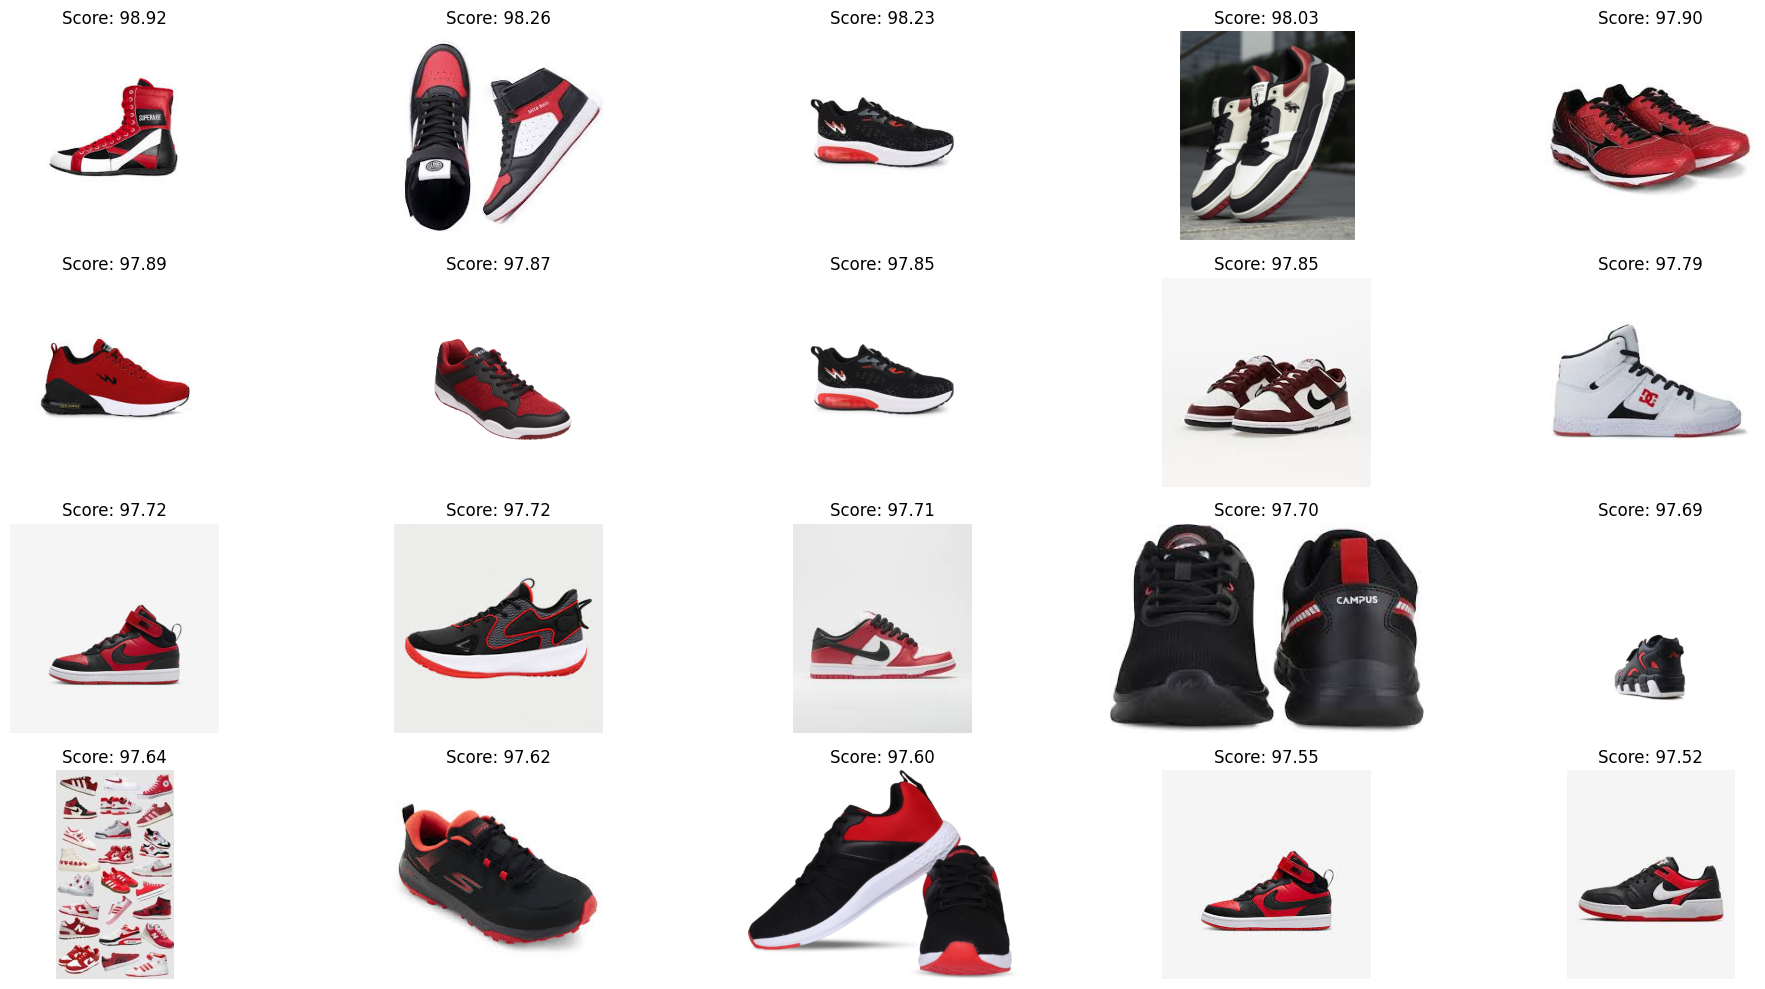

In [5]:
import cv2 as cv
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import os
from colorspacious import cspace_convert
import matplotlib.pyplot as plt

class Image:
    def __init__(self, path):
        self.path = path
        self.img = cv.imread(path)
        if self.img is None:
            raise ValueError(f"Error loading image at {path}. Please check the file path.")
        self.colors = None
        self.palette = None
        self.percentages = None
        
    def process_image(self):
        """Process the image to extract foreground and background color palettes"""
        # Edge detection
        edge_img = edge_detection(self.img)
        
        # Generate masks
        mask2, mask1 = generate_mask(self.img)
        
        # Segment foreground and background
        foreground_img = foreground_segmentation(self.img, mask2, edge_img)
        background_img = background_segmentation(self.img, mask1, edge_img)
        
        # Extract color palettes
        self.colors, self.palette, self.percentages = foreground_palette(foreground_img)

def edge_detection(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = np.float32(img)
    
    dft = cv.dft(img, flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols, 2), np.uint8)
    r = 100
    cv.circle(mask, (ccol, crow), r, (0, 0), thickness=-1)
    
    filtered_dft_shift = dft_shift * mask
    idft_shift = np.fft.ifftshift(filtered_dft_shift)
    img_back = cv.idft(idft_shift)
    img_back = cv.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    return img_back

def generate_mask(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    
    # Define a dynamic rectangle based on image dimensions
    height, width = img.shape[:2]
    rect = (10, 10, width - 20, height - 20)  # 10 pixels margin
    
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    
    cv.grabCut(img, mask, rect, bgd_model, fgd_model, 5, cv.GC_INIT_WITH_RECT)
    
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    mask1 = np.where((mask == 2) | (mask == 0), 1, 0).astype('uint8')
    return mask2, mask1

def foreground_segmentation(img, mask2, img_back):
    foreground = img * mask2[:, :, np.newaxis]
    
    img_back_3ch = cv.normalize(img_back, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    img_back_3ch = cv.merge([img_back_3ch, img_back_3ch, img_back_3ch])
    
    foreground_scaled = cv.multiply(foreground, 1)
    img_back_scaled = cv.multiply(img_back_3ch, 0.5)
    
    foreground_img = cv.add(foreground_scaled, img_back_scaled)
    return foreground_img

def background_segmentation(img, mask1, img_back):
    background = img * mask1[:, :, np.newaxis]
    
    img_back_3ch = cv.normalize(img_back, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    img_back_3ch = cv.merge([img_back_3ch, img_back_3ch, img_back_3ch])
    
    background = cv.multiply(background, 1)
    img_back_scaled = cv.multiply(img_back_3ch, 0.5)
    
    background_img = cv.add(background, img_back_scaled)
    return background_img

def foreground_palette(image, num_colors=10):
    image = cv.resize(image, (100, 100))
    pixels = image.reshape(-1, 3)
    
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)
    
    colors = kmeans.cluster_centers_.astype(int)
    
    counts = Counter(kmeans.labels_)
    total_count = sum(counts.values())
    percentages = [(counts[i] / total_count) * 100 for i in range(num_colors)]
    
    palette = np.zeros((100, 100 * num_colors, 3), dtype=int)
    for i in range(num_colors):
        palette[:, i * 100:(i + 1) * 100] = colors[i]
    
    return colors, palette, percentages

def calculate_ciede2000(color1, color2):
    lab1 = cspace_convert(color1 / 255, "sRGB1", "CIELab")
    lab2 = cspace_convert(color2 / 255, "sRGB1", "CIELab")
    delta_e = np.sqrt(np.sum((lab1 - lab2) ** 2))
    return delta_e

def find_weighted_colors(colors, weights):
    weighted_sum = np.zeros(3)
    total_weight = np.sum(weights)
    
    for color, weight in zip(colors, weights):
        weighted_sum += color * weight
    
    mid_color = weighted_sum / total_weight
    max_color = colors[np.argmax(weights)]
    min_color = colors[np.argmin(weights)]
    
    return max_color, min_color, mid_color

def calculate_similarity(user_colors, user_weights, product_colors, product_weights):
    user_max, user_min, user_mid = find_weighted_colors(user_colors, user_weights)
    product_max, product_min, product_mid = find_weighted_colors(product_colors, product_weights)
    
    distances = [
        calculate_ciede2000(user_max, product_max),
        calculate_ciede2000(user_min, product_min),
        calculate_ciede2000(user_mid, product_mid),
    ]
    
    similarity_score = sum(max(0, 1 - (distance / 100)) * 100 / 3 for distance in distances)
    return similarity_score

def load_images_from_directory(directory):
    image_objects = []
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(directory, filename)
            img_object = Image(path)
            img_object.process_image()
            image_objects.append(img_object)
    return image_objects

def compare_products_with_users(user_images, product_images):
    results = []
    
    # Convert user images to profiles
    user_profiles = []
    for user_image in user_images:
        user_profile = {
            'colors': user_image.colors,
            'weights': user_image.percentages
        }
        user_profiles.append(user_profile)
    
    # Compare each product with user profiles
    for i, product in enumerate(product_images):
        product_colors = product.colors
        product_weights = product.percentages
        
        # Find maximum similarity with any user profile
        max_similarity = 0
        for user_profile in user_profiles:
            similarity = calculate_similarity(
                user_profile['colors'],
                user_profile['weights'],
                product_colors,
                product_weights
            )
            max_similarity = max(max_similarity, similarity)
        
        results.append({
            'product_index': i,
            'product_path': product.path,
            'similarity_score': max_similarity
        })
    
    # Sort results by similarity score
    results.sort(key=lambda x: x['similarity_score'], reverse=True)
    return results

def main():
    # Define directories containing images
    user_directory = r"C:\Users\Dhile\dev\DIP\user"
    product_directory = r"C:\Users\Dhile\dev\DIP\products"
    
    # Load and process images
    print("Loading user images...")
    user_images = load_images_from_directory(user_directory)
    print(f"Loaded {len(user_images)} user images")
    
    print("Loading product images...")
    product_images = load_images_from_directory(product_directory)
    print(f"Loaded {len(product_images)} product images")
    
    # Compare products with user preferences
    print("Calculating similarity scores...")
    results = compare_products_with_users(user_images, product_images)
    
    # Print results
    print("\nResults:")
    print("-" * 50)
    for result in results:
        print(f"Product: {os.path.basename(result['product_path'])}")
        print(f"Similarity Score: {result['similarity_score']:.2f}")
        print("-" * 50)

    # Plot the top 20 images based on similarity scores
    top_n = 20
    top_results = results[:top_n]
    
    plt.figure(figsize=(20, 10))
    
    for i, result in enumerate(top_results):
        img = cv.imread(result['product_path'])
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting
        plt.subplot(4, 5, i + 1)  # Adjust the number of rows and columns as needed
        plt.imshow(img)
        plt.title(f"Score: {result['similarity_score']:.2f}")
        plt.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
## around 95% images are relavent

In [ ]:
#on avg 80% are relavent